In [1]:
import os
from typing import Tuple

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tf_utils.callbacks import schedule_fn2
from tf_utils.dogscatsDataAdvanced import DOGSCATS
from tf_utils.plotting import get_heatmap, get_occlusion

ModuleNotFoundError: No module named 'tf_utils'

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
MODELS_DIR = os.path.abspath('C:/Selbststudium/Udemy/Udemy_Tensorflow/models/')
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_FILE_PATH = os.path.join(MODELS_DIR, "dogs_cats.h5")
LOGS_DIR = os.path.abspath('C:/Selbststudium/Udemy/Udemy_Tensorflow/logs/')
if not os.path.exists(LOGS_DIR):
    os.mkdir(LOGS_DIR)

In [ ]:
def build_model(
    img_shape: Tuple[int, int, int],
    num_classes: int,
    optimizer: tf.keras.optimizers.Optimizer,
    learning_rate: float,
    filter_block1: int,
    kernel_size_block1: int,
    filter_block2: int,
    kernel_size_block2: int,
    filter_block3: int,
    kernel_size_block3: int,
    dense_layer_size: int,
    kernel_initializer: tf.keras.initializers.Initializer,
    activation_cls: tf.keras.layers.Activation,
    dropout_rate: float,
    use_batch_normalization: bool,
    use_dense: bool,
    use_global_pooling: bool
) -> Model:
    input_img = Input(shape=img_shape)

    x = Conv2D(
        filters=filter_block1,
        kernel_size=kernel_size_block1,
        padding="same",
        kernel_initializer=kernel_initializer,
        name="heatmap1"
    )(input_img)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    x = activation_cls(x)
    x = Conv2D(
        filters=filter_block1,
        kernel_size=kernel_size_block1,
        padding="same",
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    if dropout_rate:
        x = Dropout(rate=dropout_rate)(x)
    x = activation_cls(x)
    x = MaxPool2D()(x)

    x = Conv2D(
        filters=filter_block2,
        kernel_size=kernel_size_block2,
        padding="same",
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    x = activation_cls(x)
    x = Conv2D(
        filters=filter_block2,
        kernel_size=kernel_size_block2,
        padding="same",
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    if dropout_rate:
        x = Dropout(rate=dropout_rate)(x)
    x = activation_cls(x)
    x = MaxPool2D()(x)

    x = Conv2D(
        filters=filter_block3,
        kernel_size=kernel_size_block3,
        padding="same",
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    x = activation_cls(x)
    x = Conv2D(
        filters=filter_block3,
        kernel_size=kernel_size_block3,
        padding="same",
        kernel_initializer=kernel_initializer
    )(x)
    if use_batch_normalization:
        x = BatchNormalization()(x)
    if dropout_rate:
        x = Dropout(rate=dropout_rate)(x)
    x = activation_cls(x)
    x = MaxPool2D()(x)

    if use_global_pooling:
        x = GlobalAveragePooling2D()(x)
    else:
        x = Flatten()(x)
    if use_dense:
        x = Dense(
            units=dense_layer_size,
            kernel_initializer=kernel_initializer
        )(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = activation_cls(x)
    x = Dense(
        units=num_classes,
        kernel_initializer=kernel_initializer
    )(x)
    y_pred = Activation("softmax")(x)

    model = Model(
        inputs=[input_img],
        outputs=[y_pred]
    )

    opt = optimizer(learning_rate=learning_rate)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=opt,
        metrics=["accuracy"]
    )

    return model

In [ ]:
data = DOGSCATS()

train_dataset = data.get_train_set()
val_dataset = data.get_val_set()
test_dataset = data.get_test_set()

img_shape = data.img_shape
num_classes = data.num_classes

# Global params
epochs = 100
batch_size = 128

params = {
    "dense_layer_size": 128,
    "kernel_initializer": "GlorotUniform",
    "optimizer": Adam,
    "learning_rate": 1e-3,
    "filter_block1": 32,
    "kernel_size_block1": 3,
    "filter_block2": 64,
    "kernel_size_block2": 3,
    "filter_block3": 128,
    "kernel_size_block3": 3,
    "activation_cls": ReLU(),
    "dropout_rate": 0.0,
    "use_batch_normalization": True,
    "use_dense": True,
    "use_global_pooling": True
}

model = build_model(
    img_shape,
    num_classes,
    **params
)

lrs_callback = LearningRateScheduler(
    schedule=schedule_fn2,
    verbose=1
)

es_callback = EarlyStopping(
    monitor="val_accuracy",
    patience=30,
    verbose=1,
    restore_best_weights=True
)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
model.fit(
    train_dataset,
    verbose=1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[lrs_callback, es_callback],
    validation_data=val_dataset,
)

model.save_weights(filepath=MODEL_FILE_PATH)

Test performance: [0.16825303435325623, 0.957485556602478]


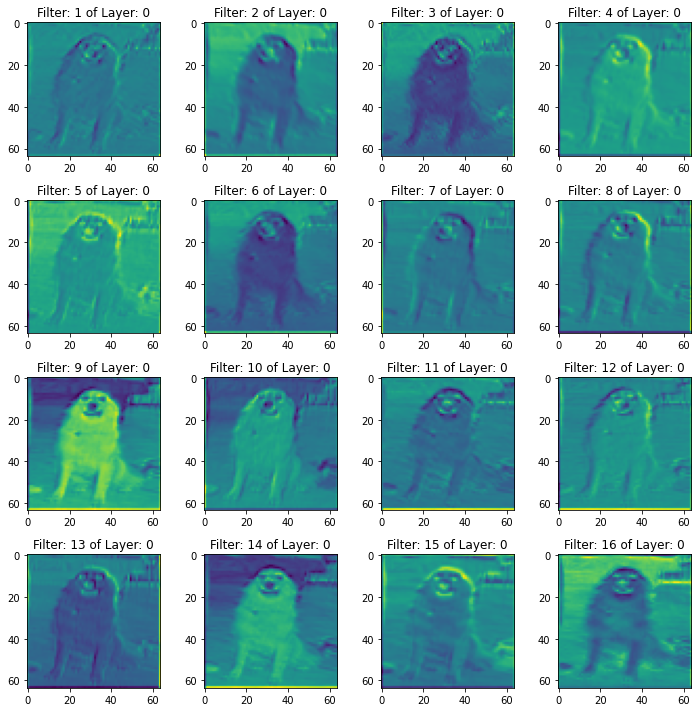

In [ ]:
model.load_weights(filepath=MODEL_FILE_PATH)

score = model.evaluate(
    val_dataset,
    verbose=0,
    batch_size=batch_size)
print(f"Test performance: {score}")

data_tuple = test_dataset.take(1).as_numpy_iterator().next()
img = data_tuple[0][0]

get_heatmap(img=img, model=model)

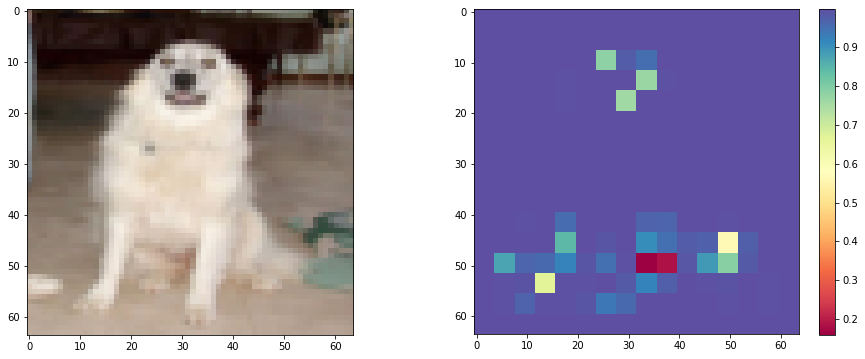

In [ ]:
label = data_tuple[1][0]

get_occlusion(
    img=img,
    label=label,
    box_size=4,
    step_size=4,
    model=model
)

In der Occlusion Map wird ein Quadrat über das Bild geschoben und dann bewertet, ob sich die Prediction mit der nun fehlenden Information verändert hätte.
Blau bedeutet keine Änderung, rot hieße der verdeckte Bereich wäre sehr wichtig für die Prediction